In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import sys
import tensorflow_io as tfio
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

2023-07-12 05:17:35.964739: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-12 05:17:35.964762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
SEED = 1337
EPOCHS = 5
BATCH_SIZE = 64
VALIDATION_RATIO = 0.1
MODEL_NAME = "uk_irish_accent_recognition"

# Location where the dataset will be downloaded.
# By default (None), keras.utils.get_file will use ~/.keras/ as the CACHE_DIR
CACHE_DIR = None

# The location of the dataset
URL_PATH = "https://www.openslr.org/resources/83/"

# List of datasets compressed files that contain the audio files
zip_files = {
    0: "irish_english_male.zip",
    1: "midlands_english_female.zip",
    2: "midlands_english_male.zip",
    3: "northern_english_female.zip",
    4: "northern_english_male.zip",
    5: "scottish_english_female.zip",
    6: "scottish_english_male.zip",
    7: "southern_english_female.zip",
    8: "southern_english_male.zip",
    9: "welsh_english_female.zip",
    10: "welsh_english_male.zip",
}

# We see that there are 2 compressed files for each accent (except Irish):
# - One for male speakers
# - One for female speakers
# However, we will using a gender agnostic dataset.

# List of gender agnostic categories
gender_agnostic_categories = [
    "ir",  # Irish
    "mi",  # Midlands
    "no",  # Northern
    "sc",  # Scottish
    "so",  # Southern
    "we",  # Welsh
]

class_names = [
    "Irish",
    "Midlands",
    "Northern",
    "Scottish",
    "Southern",
    "Welsh",
    "Not a Speech"
]

keras.utils.set_random_seed(SEED)


In [3]:
yamnet_model = hub.load("https://tfhub.dev/google/yamnet/1")


2023-07-12 05:17:38.285763: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-12 05:17:38.285785: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-12 05:17:38.285807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prakash-Inspiron-3505): /proc/driver/nvidia/version does not exist
2023-07-12 05:17:38.286002: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
dataframe = pd.read_csv('/home/prakash/Desktop/line_index_dev.csv',names=["id", "filename", "transcript"], usecols=["filename"])
dataframe.head()

,filename
0,wef_12484_01482829612
1,wef_12484_01345932698
2,wef_12484_00999757777
3,wef_12484_00036278823
4,wef_12484_00458512623


In [7]:
# The purpose of this function is to preprocess the dataframe by applying the following:
# - Cleaning the filename from a leading space
# - Generating a label column that is gender agnostic i.e.
#   welsh english male and welsh english female for example are both labeled as
#   welsh english
# - Add extension .wav to the filename
# - Shuffle samples
def preprocess_dataframe(dataframe):
    # Remove leading space in filename column
    dataframe["filename"] = dataframe.apply(lambda row: row["filename"].strip(), axis=1)

    # Create gender agnostic labels based on the filename first 2 letters
    dataframe["label"] = dataframe.apply(
        lambda row: gender_agnostic_categories.index(row["filename"][:2]), axis=1
    )

    # Add the file path to the name
    dataframe["filename"] = dataframe.apply(
        lambda row: os.path.join( '/media/prakash/New Volume/english_dialect_classification/Yamnet/YamnetData', row["filename"] + ".wav"), axis=1
    )

    # Shuffle the samples
    dataframe = dataframe.sample(frac=1, random_state=SEED).reset_index(drop=True)

    return dataframe


dataframe = preprocess_dataframe(dataframe)
dataframe.head()


,filename,label
0,/media/prakash/New Volume/english_dialect_clas...,3
1,/media/prakash/New Volume/english_dialect_clas...,2
2,/media/prakash/New Volume/english_dialect_clas...,1
3,/media/prakash/New Volume/english_dialect_clas...,1
4,/media/prakash/New Volume/english_dialect_clas...,3


In [8]:
split = int(len(dataframe) * (1 - VALIDATION_RATIO))
train_df = dataframe[:split]
valid_df = dataframe[split:]

print(
    f"We have {train_df.shape[0]} training samples & {valid_df.shape[0]} validation ones"
)

We have 81 training samples & 9 validation ones


In [9]:
@tf.function
def load_16k_audio_wav(filename):
    # Read file content
    file_content = tf.io.read_file(filename)

    # Decode audio wave
    audio_wav, sample_rate = tf.audio.decode_wav(file_content, desired_channels=1)
    audio_wav = tf.squeeze(audio_wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    # Resample to 16k
    audio_wav = tfio.audio.resample(audio_wav, rate_in=sample_rate, rate_out=16000)

    return audio_wav


def filepath_to_embeddings(filename, label):
    # Load 16k audio wave
    audio_wav = load_16k_audio_wav(filename)

    # Get audio embeddings & scores.
    # The embeddings are the audio features extracted using transfer learning
    # while scores will be used to identify time slots that are not speech
    # which will then be gathered into a specific new category 'other'
    scores, embeddings, _ = yamnet_model(audio_wav)

    # Number of embeddings in order to know how many times to repeat the label
    embeddings_num = tf.shape(embeddings)[0]
    labels = tf.repeat(label, embeddings_num)

    # Change labels for time-slots that are not speech into a new category 'other'
    labels = tf.where(tf.argmax(scores, axis=1) == 0, label, len(class_names) - 1)

    # Using one-hot in order to use AUC
    return (embeddings, tf.one_hot(labels, len(class_names)))


def dataframe_to_dataset(dataframe, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["filename"], dataframe["label"])
    )

    dataset = dataset.map(
        lambda x, y: filepath_to_embeddings(x, y),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    ).unbatch()

    return dataset.cache().batch(batch_size, True).prefetch(tf.data.AUTOTUNE)


train_ds = dataframe_to_dataset(train_df, BATCH_SIZE)
valid_ds = dataframe_to_dataset(valid_df, BATCH_SIZE)


2023-07-12 05:23:16.038353: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


In [10]:
# sys.path.append('/workspaces/codespaces-blank/models')
sys.path.append('/home/prakash/Desktop/models')
from models.Quantum_e2e_model_Bswain_English import HybridModel

In [11]:
model=HybridModel() 

In [12]:
# Normal Training

model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1.9644e-5),
        # loss=keras.losses.MeanSquaredError(),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS);

Epoch 1/5
16/16 [==============================] - 33s 1s/step - loss: 1.8603 - accuracy: 0.2109 - auc: 0.5974 - val_loss: 1.7226 - val_accuracy: 0.2812 - val_auc: 0.7315
Epoch 2/5
16/16 [==============================] - 26s 2s/step - loss: 1.7872 - accuracy: 0.3477 - auc: 0.6671 - val_loss: 1.6861 - val_accuracy: 0.4375 - val_auc: 0.7821
Epoch 3/5
16/16 [==============================] - 27s 2s/step - loss: 1.7520 - accuracy: 0.3994 - auc: 0.7030 - val_loss: 1.6591 - val_accuracy: 0.4219 - val_auc: 0.8166
Epoch 4/5
16/16 [==============================] - 16s 1s/step - loss: 1.7283 - accuracy: 0.4238 - auc: 0.7352 - val_loss: 1.6545 - val_accuracy: 0.4531 - val_auc: 0.8200
Epoch 5/5
16/16 [==============================] - 16s 1s/step - loss: 1.7157 - accuracy: 0.4375 - auc: 0.7536 - val_loss: 1.6521 - val_accuracy: 0.4688 - val_auc: 0.8077


In [14]:
# Custom Training

# Define the loss function and optimizer
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

# Training loop
epochs = 5
for epoch in range(epochs):
    for feats_batch, labels_batch in train_ds:
        with tf.GradientTape() as tape:
            # Forward pass
            logits = model(feats_batch)
            loss_value = loss_fn(labels_batch, logits)

        # Compute gradients
        gradients = tape.gradient(loss_value, model.trainable_variables)

        # Update model parameters
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Print the loss every 100 epochs
    print(f"Epoch {epoch + 1}: Loss = {loss_value.numpy()}")


Epoch 1: Loss = 0.11602839827537537
Epoch 2: Loss = 0.11511125415563583
Epoch 3: Loss = 0.11353640258312225
Epoch 4: Loss = 0.11330747604370117
Epoch 5: Loss = 0.11245152354240417


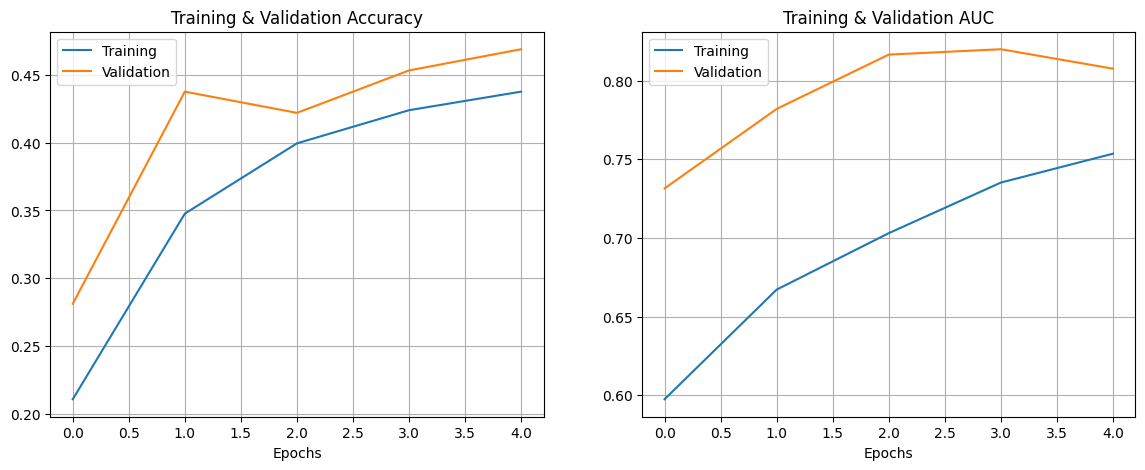

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axs[0].plot(range(EPOCHS), history.history["accuracy"], label="Training")
axs[0].plot(range(EPOCHS), history.history["val_accuracy"], label="Validation")
axs[0].set_xlabel("Epochs")
axs[0].set_title("Training & Validation Accuracy")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(range(EPOCHS), history.history["auc"], label="Training")
axs[1].plot(range(EPOCHS), history.history["val_auc"], label="Validation")
axs[1].set_xlabel("Epochs")
axs[1].set_title("Training & Validation AUC")
axs[1].legend()
axs[1].grid(True)

plt.show()

In [16]:
train_loss, train_acc, train_auc = model.evaluate(train_ds)
valid_loss, valid_acc, valid_auc = model.evaluate(valid_ds)

1/1 [==============================] - 0s 464ms/step - loss: 1.6861 - accuracy: 0.5000 - auc: 0.7914


In [17]:
# The following function calculates the d-prime score from the AUC
def d_prime(auc):
    standard_normal = stats.norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime


print(
    "train d-prime: {0:.3f}, validation d-prime: {1:.3f}".format(
        d_prime(train_auc), d_prime(valid_auc)
    )
)

train d-prime: 0.945, validation d-prime: 1.147


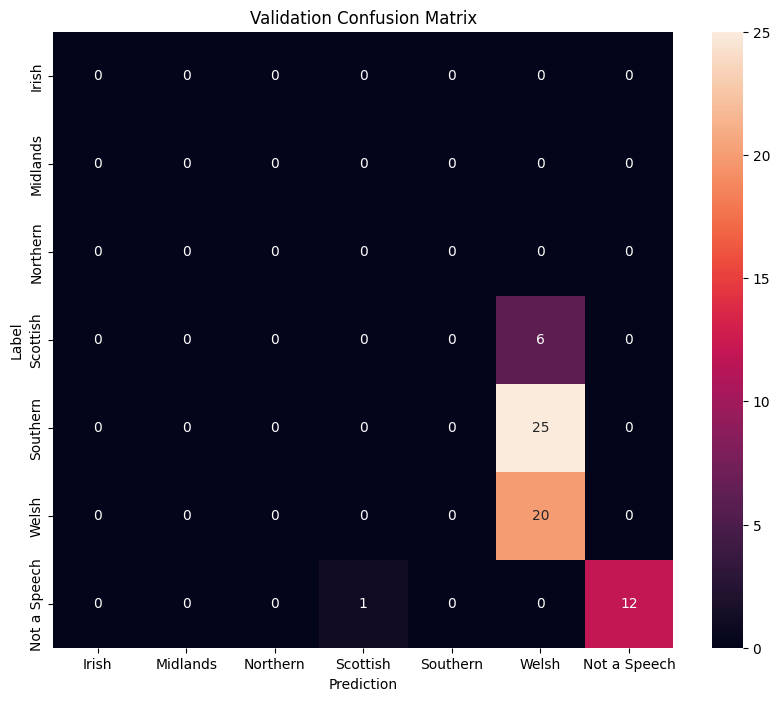

In [18]:
# Create x and y tensors
x_valid = None
y_valid = None

for x, y in valid_ds:
    if x_valid is None:
        x_valid = x.numpy()
        y_valid = y.numpy()
    else:
        x_valid = np.concatenate((x_valid, x.numpy()), axis=0)
        y_valid = np.concatenate((y_valid, y.numpy()), axis=0)



# Generate predictions
y_pred = model.predict(x_valid, batch_size=BATCH_SIZE)

# Calculate confusion matrix
confusion_mtx = tf.math.confusion_matrix(
    np.argmax(y_valid, axis=1), np.argmax(y_pred, axis=1)
)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=class_names, yticklabels=class_names, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.title("Validation Confusion Matrix")
plt.show()

In [19]:
for i, label in enumerate(class_names):
    precision = confusion_mtx[i, i] / np.sum(confusion_mtx[:, i])
    recall = confusion_mtx[i, i] / np.sum(confusion_mtx[i, :])
    print(
        "{0:15} Precision:{1:.2f}%; Recall:{2:.2f}%".format(
            label, precision * 100, recall * 100
        )
    )

Irish           Precision:nan%; Recall:nan%
Midlands        Precision:nan%; Recall:nan%
Northern        Precision:nan%; Recall:nan%
Scottish        Precision:0.00%; Recall:0.00%
Southern        Precision:nan%; Recall:0.00%
Welsh           Precision:39.22%; Recall:100.00%
Not a Speech    Precision:100.00%; Recall:92.31%
